<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [16]</a>'.</span>

In [1]:
import numpy as np
import datetime as dt
import os
import pandas as pd
import math
import scipy
import requests
import warnings
import json
import h5py
from pyproj import Proj, CRS
import pysolid
import matplotlib.pyplot as plt
import rasterio as rio
from isce3.core import Ellipsoid as ellips
import geopandas as gpd
import shapely.wkt as wkt
from shapely import geometry
import folium

from src.ALE_utils import oversample_slc, findCR, interpolate_correction_layers
warnings.filterwarnings('ignore')

# 0. Read OPERA Coregistered SLC

In [2]:
# Parameters
wdir = "/mnt/trappist-r0/bato/work/ROSAMOND/COMPASS_TEST/A064/stack/"
burst_id = "t064_135523_iw2"
date = "20210301"


In [3]:
pol = 'VV'
path_h5 = f'{wdir}/{burst_id}/{date}/{burst_id}_{date}.h5'


In [4]:
# Load the CSLC and necessary metadata
DATA_ROOT = 'science/SENTINEL1'
grid_path = f'{DATA_ROOT}/CSLC/grids'
metadata_path = f'{DATA_ROOT}/CSLC/metadata'
burstmetadata_path = f'{DATA_ROOT}/CSLC/metadata/processing_information/s1_burst_metadata'
id_path = f'{DATA_ROOT}/identification'

with h5py.File(path_h5,'r') as h5:
    cslc = h5[f'{grid_path}/{pol}'][:]
    xcoor = h5[f'{grid_path}/x_coordinates'][:]
    ycoor = h5[f'{grid_path}/y_coordinates'][:]
    dx = h5[f'{grid_path}/x_spacing'][()].astype(int)
    dy = h5[f'{grid_path}/y_spacing'][()].astype(int)
    epsg = h5[f'{grid_path}/projection'][()].astype(int)
    sensing_start = h5[f'{burstmetadata_path}/sensing_start'][()].astype(str)
    sensing_stop = h5[f'{burstmetadata_path}/sensing_stop'][()].astype(str)
    dims = h5[f'{burstmetadata_path}/shape'][:]
    bounding_polygon =h5[f'{id_path}/bounding_polygon'][()].astype(str) 
    orbit_direction = h5[f'{id_path}/orbit_pass_direction'][()].astype(str)


In [5]:
# Visualize burst location on a map
cslc_poly = wkt.loads(bounding_polygon)
bbox = [cslc_poly.bounds[0], cslc_poly.bounds[2], cslc_poly.bounds[1], cslc_poly.bounds[3]]
m = folium.Map(location=[np.mean(bbox[2:3]), np.mean(bbox[0:1])], zoom_start=9, tiles='CartoDB positron')
gdf_cslc = gpd.GeoDataFrame(index=[0], crs=f'epsg:{epsg}', geometry=[cslc_poly])
geoj_cslc = gdf_cslc.to_json()
geoj_cslc = folium.GeoJson(data=geoj_cslc,
                        style_function=lambda x: {'fillColor': 'orange'})
geoj_cslc.add_to(m)
m

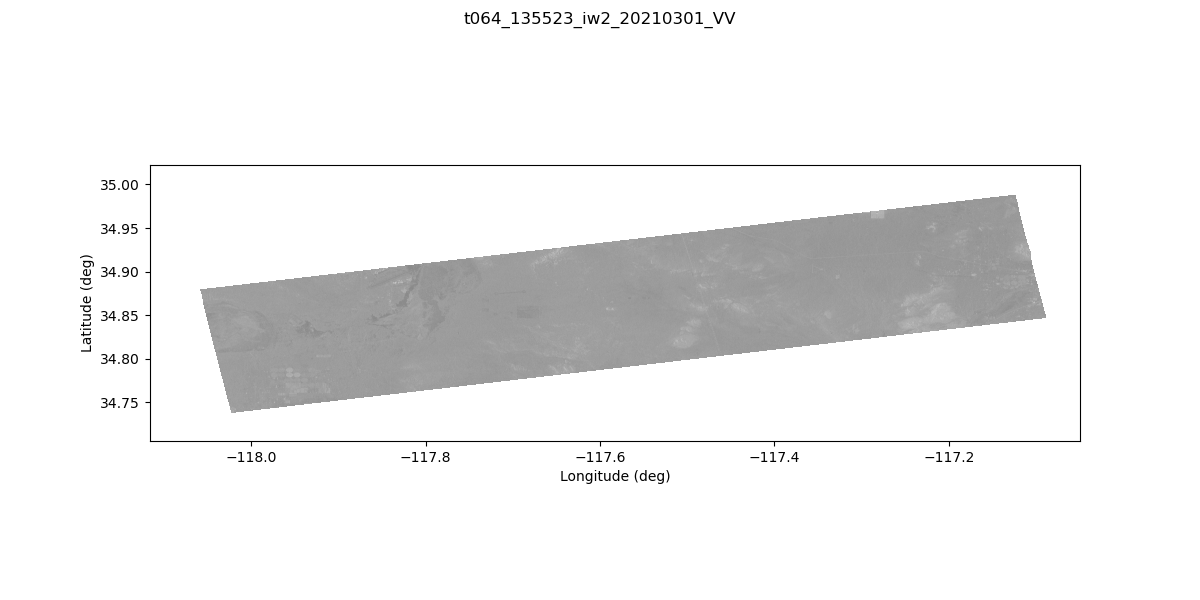

In [6]:
# Visualize CSLC
%matplotlib widget
#bbox = [xcoor.min(),xcoor.max(),ycoor.min(),ycoor.max()]
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(20*np.log10(np.abs(cslc)), cmap='gray',interpolation=None, extent=bbox)
fig.suptitle(f'{burst_id}_{date}_{pol}')
ax.set_aspect(1)
ax.set_xlabel('Longitude (deg)')
ax.set_ylabel('Latitude (deg)')
fig.savefig('cslc.png',dpi=300,bbox_inches='tight')

In [7]:
path_ramp_h5 = f'{wdir}/{burst_id}/{date}/{burst_id}_{date}_ramp.h5'

with h5py.File(path_ramp_h5,'r') as h5:
    ramp = h5[f'{grid_path}/{pol}'][:]     #reading geocoded ramp
    
cslc = cslc * np.conj(ramp)    #deramped geocoded CSLC

# 1. Get corner reflectors data

In [8]:
# Check if the CR data already exists
if os.path.exists(f'crdata_{date}.csv') == False:
    # Get the cslc date
    date_ = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f').strftime('%Y-%m-%d+%H\u0021%M')

    # Download corner reflector data from NISAR based on the date of the CSLC product
    res = requests.get(f'https://uavsar.jpl.nasa.gov/cgi-bin/corner-reflectors.pl?date={str(date_)}&project=uavsar')
    open(f'crdata_{date}.csv', 'wb').write(res.content)

else:
    print(f'Corner Reflector Data: crdata_{date}.csv already exists. Skipping download.')

# Read to pandas dataframe and rename columns
df = pd.read_csv(f'crdata_{date}.csv')
df.rename(columns={'Corner reflector ID':'ID'}, inplace=True)
df.rename(columns={'Latitude (deg)':'lat'}, inplace=True) 
df.rename(columns={'Longitude (deg)':'lon'}, inplace=True) 
df.rename(columns={'Azimuth (deg)':'azm'}, inplace=True)
df.rename(columns={'Tilt / Elevation angle (deg)':'tilt'}, inplace=True)
df.rename(columns={'Height above ellipsoid (m)':'hgt'}, inplace=True) 
df.rename(columns={'Side length (m)':'slen'}, inplace=True)

df.head()

Corner Reflector Data: crdata_20210301.csv already exists. Skipping download.


,ID,lat,lon,hgt,azm,tilt,slen
0,0,34.796969,-118.096530,660.7941,170.0,12.20,2.4384
1,1,34.799773,-118.086995,660.9972,170.0,12.40,2.4384
2,2,34.805237,-118.087388,660.8043,169.5,9.20,2.4384
3,3,34.805342,-118.081910,660.9539,176.0,13.00,2.4384
4,4,34.805415,-118.076377,661.1631,176.0,12.03,2.4384


In [9]:
#calculating the locations of CRs in SAR image
UTMx = []
UTMy = []
xindex = []
yindex = []
xloc = []
yloc = []
_in = []

for idx, row in df.iterrows():
    
    _Proj = Proj(CRS.from_epsg(epsg))
    _x, _y = _Proj(row['lon'], row['lat'],inverse=False)     #conversion of lat/lon of CRs to UTM coordinates
    
    #Indices of the CRs in SLC image
    _xloc = int((_x-xcoor[0])/dx)    
    _yloc = int((_y-ycoor[0])/dy)
    
    UTMx.append(_x) 
    UTMy.append(_y)
    xindex.append(_xloc)
    yindex.append(_yloc)
    xloc.append((_x-xcoor[0])/dx)
    yloc.append((_y-ycoor[0])/dy)
    _in.append(cslc_poly.contains(geometry.Point(row['lon'],row['lat'])))
    
df['UTMx'] = UTMx
df['UTMy'] = UTMy
df['CR_xindex'] = xindex
df['CR_yindex'] = yindex
df['CR_xloc'] = xloc
df['CR_yloc'] = yloc
df['inPoly'] = _in

#checking whether CRs are in SLC coverage. Including only CRs within SLC image
df = df[df['inPoly']==True]
df.drop('inPoly', axis=1, inplace=True)
df = df.reset_index(drop=True)
df.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,CR_xindex,CR_yindex,CR_xloc,CR_yloc
0,0,34.796969,-118.096530,660.7941,170.0,12.20,2.4384,399691.142063,3.851076e+06,1287,3026,1287.728413,3026.911020
1,1,34.799773,-118.086995,660.9972,170.0,12.40,2.4384,400566.779277,3.851377e+06,1462,2996,1462.855855,2996.764638
2,2,34.805237,-118.087388,660.8043,169.5,9.20,2.4384,400537.370941,3.851984e+06,1456,2936,1456.974188,2936.126027
3,3,34.805342,-118.081910,660.9539,176.0,13.00,2.4384,401038.637285,3.851990e+06,1557,2935,1557.227457,2935.503706
4,4,34.805415,-118.076377,661.1631,176.0,12.03,2.4384,401544.788008,3.851993e+06,1658,2935,1658.457602,2935.238365


In [10]:
dateformat = '%Y-%m-%d %H:%M:%S.%f'  #date format of input azimuth time
dt0 = dt.datetime.strptime(sensing_start,dateformat)
dt1 = dt.datetime.strptime(sensing_stop,dateformat)
step_sec = 5                        # sample spacing in time domain in seconds

for idx, row in df.iterrows():
    
    llh = [np.deg2rad(row['lon']), np.deg2rad(row['lat']), row['hgt']]  #lon/lat/hgt
    
    _elp = ellips()
    xyz = _elp.lon_lat_to_xyz(llh) #xyz coordinate of CR
    
    # compute SET via pysolid
    (dt_out,
     tide_e,
     tide_n,
     tide_u) = pysolid.calc_solid_earth_tides_point(np.rad2deg(llh[1]), np.rad2deg(llh[0]), dt0, dt1,
                                                step_sec=step_sec,
                                                display=False,
                                                verbose=False)
    
    tide_e = np.mean(tide_e[0:2])
    tide_n = np.mean(tide_n[0:2])
    tide_u = np.mean(tide_u[0:2])
    
    #updating lat,lon,hgt after SET correction
    xyz = [xyz[0]+tide_e, xyz[1]+tide_n, xyz[2]+tide_u]
    llh = _elp.xyz_to_lon_lat(xyz)  
    
    df.loc[idx,'lat'] = np.rad2deg(llh[1])
    df.loc[idx,'lon'] = np.rad2deg(llh[0])
    df.loc[idx,'hgt'] = llh[2]   

PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.79696911/-118.09653004 degree
PYSOLID: start UTC: 2021-03-01T01:50:00.693268
PYSOLID: end   UTC: 2021-03-01T01:50:03.793047
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.799773/-118.08699519000001 degree
PYSOLID: start UTC: 2021-03-01T01:50:00.693268
PYSOLID: end   UTC: 2021-03-01T01:50:03.793047
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80523737/-118.08738843000002 degree
PYSOLID: start UTC: 2021-03-01T01:50:00.693268
PYSOLID: end   UTC: 2021-03-01T01:50:03.793047
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Earth tides in east/north/up direction
PYSOLID: lot/lon: 34.80534232/-118.08190986999999 degree
PYSOLID: start UTC: 2021-03-01T01:50:00.693268
PYSOLID: end   UTC: 2021-03-01T01:50:03.793047
PYSOLID: time step: 5 seconds
PYSOLID: calculate solid Ear

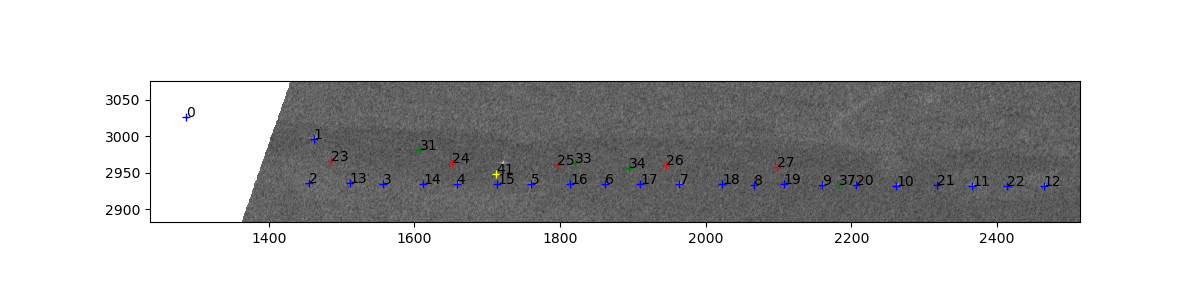

In [11]:
#Displaying SLC image
buffer = 50
minX = df['CR_xindex'].min() - buffer
maxX = df['CR_xindex'].max() + buffer
minY = df['CR_yindex'].min() - buffer
maxY = df['CR_yindex'].max() + buffer

scale_ = 1.0
exp_ = 0.15

fig, ax = plt.subplots(figsize=(12, 3))
cax=ax.imshow(scale_*(np.abs(cslc))**exp_, cmap='gray',interpolation=None, origin='upper')
ax.set_xlim(minX,maxX)
ax.set_ylim(minY,maxY)
#ax.axis('off')

for sl in pd.unique(df.slen):
    xx = df.loc[df['slen']==sl]['CR_xindex']
    yy = df.loc[df['slen']==sl]['CR_yindex']
    ID = df.loc[df['slen']==sl]['ID']
    
    if sl == 2.4384:
        color='blue'
    elif sl == 4.8:
        color='red'
    elif sl == 2.8:
        color='yellow'
    else:
        color='green'
    
    ax.scatter(xx,yy,color=color,marker="+",lw=1)
    for _ID,_xx,_yy in zip(ID,xx,yy):
        ax.annotate(_ID, (_xx, _yy), fontsize=10)

ax.set_aspect(1)
fig.savefig('S1_geoSLC_CRs.png',dpi=300,bbox_inches='tight')

In [12]:
# selecting CRs according to orbit direction
if orbit_direction == 'Descending':
    df_filter = df[df['azm']>340].reset_index(drop=True)
    #only east-looking CRs (for right-looking descending)
else:  #ASCENDING
    df_filter = df[df['azm']<200].reset_index(drop=True)    
    #only west-looking CRs (for right-looking ascending)

df_filter = df_filter.loc[df_filter['slen']>0.8].reset_index(drop=True)   #excluding SWOT CRs (0.7 m as a side length)
df = None

In [13]:
from src.ALE_utils import oversample_slc, findCR

xpeak = []
ypeak = []

for ID, xoff, yoff in zip(df_filter['ID'],df_filter['CR_xindex'],df_filter['CR_yindex']):
    # crop a patch of 10*10 with center at the calculated CR position
    pxbuff = 5
    pybuff = 5
    cropcslc = cslc[(yoff-pybuff):(yoff+pybuff+1),(xoff-pxbuff):(xoff+pxbuff+1)]
    
    # find the peak amplitude in the 10*10 patch
    yind,xind = np.unravel_index(np.argmax(np.abs(cropcslc), axis=None), cropcslc.shape)
    
    # give a warning if the peak and the calculated postion are too far
    dyind = yind-pybuff; dxind = xind-pxbuff
    dist = math.sqrt(dyind**2+dxind**2)
    if dist > 5.0:
        warnings.warn(f'the most bright pixel and the xindex is too far for CR {ID}')
    
    # crop a patch of 32*32 but with its center at the peak
    xbuff = 16
    ybuff = 16
    ycrop = np.arange(yoff+dyind-ybuff,yoff+dyind+ybuff+1)
    xcrop = np.arange(xoff+dxind-xbuff,xoff+dxind+xbuff+1)
    cropcslc = cslc[ycrop,:][:,xcrop]

    # oversample this 32*32 patch by 32
    ovsFactor = 32
    cropcslc_ovs,ycrop_ovs,xcrop_ovs = oversample_slc(cropcslc,sampling=ovsFactor,y=ycrop,x=xcrop)

    # find the peak amplitude again in a 2 x 2 patch, it correspond to 
    # (2*ovsFactor) x (2*ovsFactor) in oversampled slc
    yoff2 = int(cropcslc_ovs.shape[0]/2)
    xoff2 = int(cropcslc_ovs.shape[1]/2)
    cropcslc2 = cropcslc_ovs[yoff2-ovsFactor:yoff2+ovsFactor+1,
                           xoff2-ovsFactor:xoff2+ovsFactor+1]
    yind2,xind2 = np.unravel_index(np.argmax(abs(cropcslc2), axis=None), cropcslc2.shape)
    dyind2 = yind2-ovsFactor; dxind2 = xind2-ovsFactor

    # crop a patch of 3x3 oversampled patch with center at the peak
    cropcslc2 = cropcslc_ovs[yoff2+dyind2-1:yoff2+dyind2+2,xoff2+dxind2-1:xoff2+dxind2+2]
    ycrop2 = ycrop_ovs[yoff2+dyind2-1:yoff2+dyind2+2]
    xcrop2 = xcrop_ovs[xoff2+dxind2-1:xoff2+dxind2+2]
    xxcrop2,yycrop2 = np.meshgrid(xcrop2,ycrop2)
    xxcrop2_f = xxcrop2.flatten()
    yycrop2_f = yycrop2.flatten()
    cropcslc2_f = cropcslc2.flatten()

    # Check if pixel values in a patch are non-NaN
    valid = ~(np.isnan(cropcslc2_f))
    count_valid = np.count_nonzero(valid)

    if count_valid == 0:
        _ypeak, _xpeak = [np.nan, np.nan]

    else:
        _ypeak,_xpeak = findCR(np.abs(cropcslc2_f[valid]),yycrop2_f[valid],xxcrop2_f[valid],
                            x_bound=[xcrop2[0],xcrop2[-1]],y_bound=[ycrop2[0],ycrop2[-1]],method="para")

    xpeak.append(_xpeak)
    ypeak.append(_ypeak)

df_filter['CSLC_xloc'] = xpeak
df_filter['CSLC_yloc'] = ypeak

In [14]:
df_filter = df_filter.dropna()
df_filter

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,CR_xindex,CR_yindex,CR_xloc,CR_yloc,CSLC_xloc,CSLC_yloc
1,1,34.799772,-118.086995,660.937311,170.0,12.40,2.4384,400566.779277,3.851377e+06,1462,2996,1462.855855,2996.764638,1463.935020,2996.625000
2,2,34.805236,-118.087389,660.744395,169.5,9.20,2.4384,400537.370941,3.851984e+06,1456,2936,1456.974188,2936.126027,1458.111527,2936.074937
3,3,34.805341,-118.081910,660.893976,176.0,13.00,2.4384,401038.637285,3.851990e+06,1557,2935,1557.227457,2935.503706,1558.133222,2935.396264
4,4,34.805414,-118.076378,661.103156,176.0,12.03,2.4384,401544.788008,3.851993e+06,1658,2935,1658.457602,2935.238365,1659.443488,2935.202512
5,5,34.805492,-118.070803,661.172837,172.0,11.10,2.4384,402054.831294,3.851996e+06,1760,2934,1760.466259,2934.916381,1761.566634,2934.723434
6,6,34.805583,-118.065225,661.199917,172.0,10.80,2.4384,402565.129890,3.852001e+06,1862,2934,1862.525978,2934.449427,1863.637044,2934.468750
7,7,34.805668,-118.059666,661.262998,174.0,13.80,2.4384,403073.727775,3.852005e+06,1964,2934,1964.245555,2934.044391,1965.215584,2933.968930
8,8,34.805750,-118.054073,661.376778,172.5,10.80,2.4384,403585.424162,3.852008e+06,2066,2933,2066.584832,2933.675840,2067.431533,2933.609388
9,9,34.805813,-118.048915,661.393360,175.0,11.16,2.4384,404057.339403,3.852010e+06,2160,2933,2160.967881,2933.477155,2162.010137,2933.404091
10,10,34.805924,-118.043367,661.462141,174.0,8.96,2.4384,404564.974884,3.852017e+06,2262,2932,2262.494977,2932.771496,2263.491896,2932.762058


In [15]:
#absloute geolocation error in range and azimuth after corrections
ALE_Rg = (df_filter['CSLC_xloc'] -  df_filter['CR_xloc'])*dx
ALE_Az = (df_filter['CSLC_yloc'] - df_filter['CR_yloc'])*np.abs(dy)

# Add to the dataframe
df_filter.loc[:,"ALE_Rg"] = ALE_Rg
df_filter.loc[:,"ALE_Az"] = ALE_Az
df_filter.head()

,ID,lat,lon,hgt,azm,tilt,slen,UTMx,UTMy,CR_xindex,CR_yindex,CR_xloc,CR_yloc,CSLC_xloc,CSLC_yloc,ALE_Rg,ALE_Az
1,1,34.799772,-118.086995,660.937311,170.0,12.40,2.4384,400566.779277,3.851377e+06,1462,2996,1462.855855,2996.764638,1463.935020,2996.625000,5.395826,-1.396376
2,2,34.805236,-118.087389,660.744395,169.5,9.20,2.4384,400537.370941,3.851984e+06,1456,2936,1456.974188,2936.126027,1458.111527,2936.074937,5.686696,-0.510903
3,3,34.805341,-118.081910,660.893976,176.0,13.00,2.4384,401038.637285,3.851990e+06,1557,2935,1557.227457,2935.503706,1558.133222,2935.396264,4.528823,-1.074420
4,4,34.805414,-118.076378,661.103156,176.0,12.03,2.4384,401544.788008,3.851993e+06,1658,2935,1658.457602,2935.238365,1659.443488,2935.202512,4.929432,-0.358526
5,5,34.805492,-118.070803,661.172837,172.0,11.10,2.4384,402054.831294,3.851996e+06,1760,2934,1760.466259,2934.916381,1761.566634,2934.723434,5.501875,-1.929476


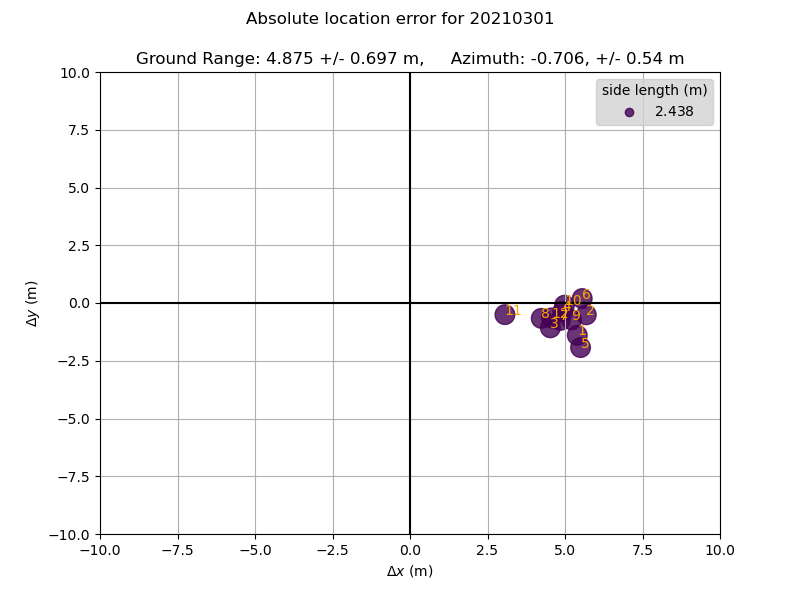

In [16]:
#plotting ALE
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(df_filter.ALE_Rg, df_filter.ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (df_filter[df_filter['ID']==txt].ALE_Rg, df_filter[df_filter['ID']==txt].ALE_Az), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'Ground Range: {np.round(np.nanmean(ALE_Rg), 3)} +/- {np.round(np.nanstd(ALE_Rg),3)} m, \
    Azimuth: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('$\Delta y$ (m)')
fig.suptitle(f'Absolute location error for {date}')
fig.savefig(f'ALE_geoSLC_deramp_{date}.png',dpi=300,bbox_inches='tight')

In [17]:
# ALE_Rg_Mean = np.round(np.nanmean(ALE_Rg), 3)
# ALE_Az_Mean = np.round(np.nanmean(ALE_Az), 3)
# ALE_Rg_Stdev = np.round(np.nanstd(ALE_Rg),3)
# ALE_Az_Stdev = np.round(np.nanstd(ALE_Az),3)

# summary = []
# summary.append([date, ALE_Rg_Mean, ALE_Rg_Stdev, ALE_Az_Mean, ALE_Az_Stdev])
# summary_df = pd.DataFrame(summary)
# summary_df.to_csv('ALE_withDeramp.csv', mode='a', header=False)

In [18]:
ds = pd.DataFrame.from_dict({'ID':df_filter['ID'],'Lat':df_filter['lat'],
                        'Lon':df_filter['lon'],'Hgt_m':df_filter['hgt']})

_CR_csv = 'used_CRs.csv'
ds.to_csv(_CR_csv,index=False)

In [19]:
import glob 
#Get orbit file
from eof.download import download_eofs

_,slcfn = os.path.split(glob.glob(f'/u/trappist-r0/bato/work/ROSAMOND/COMPASS_TEST/A064/slcs/*V_{date}*.zip')[0])
mission = slcfn[:3]
orbit_file = download_eofs(orbit_dts=[date], missions=[mission], save_dir='./orbit')[0]

In [20]:
dat = dt.datetime.strptime(sensing_start.astype(str),'%Y-%m-%d %H:%M:%S.%f')
_hour = dat.hour
_minute  = dat.minute
_second = dat.second

weather_model = 'GMAO'

with open("raider_CR.yaml", "w") as f:
    l1 = ["# vim: set filetype=yaml: \n","  look_dir: right \n","  date_group: \n"]
    l2 = ["     date_start: "+date+" \n","  time_group: \n"]
    l3 = ['      time: "'+str('{:02}'.format(_hour))+':'+str('{:02}'.format(_minute))+':'+
          str('{:02}'.format(_second))+'" \n']
    l4 = ['  weather_model: '+weather_model+'\n','  aoi_group: \n','    station_file: '+_CR_csv+'\n','\n']
    l5 = ['  height_group: \n','    height_levels: 0 50 100 500 1000  \n']
    l6 = ['  los_group: \n','    ray_trace: True \n','    zref: 500 \n']
    l7 = ['    orbit_file: '+orbit_file+'\n','  runtime_group: \n','    verbose: True \n']
    
    
    f.writelines(l1+l2+l3+l4+l5+l6+l7)
    f.close()

In [21]:
!raider.py raider_CR.yaml


t,w,f 2021-03-01 01:50:00 ./GMAO_Delay_20210301T015000.csv None
Starting to run the weather model calculation
Date: 20210301
Beginning weather model pre-processing
Weather model GMAO is available from 2014-02-20 00:00:00-Present
Number of weather model nodes: 24505
Shape of weather model: (13, 13, 145)
Bounds of the weather model: 33.25/36.25/-120.00/-116.25 (SNWE)
Weather model: GMAO
Mean value of the wet refractivity: 2.645677
Mean value of the hydrostatic refractivity: 105.008652

======Weather Model class object=====
Weather model time: 2021-03-01 01:50:00
Latitude resolution: 0.25
Longitude resolution: 0.3125
Native projection: EPSG:4326
ZMIN: -100.0
ZMAX: 15000.0
k1 = 0.776
k2 = 0.233
k3 = 3750.0
Humidity type = q
Class name: gmao
Dataset: gmao
A: []
B: []
Number of points in Lon/Lat = 13/13
Total number of grid points (3D): 24505

Output SNWE: [34.78, 34.82, -118.10000000000001, -118.02]
Output cube spacing: 0.02
Processing slice 1 / 5: 0.0
Processing slice 2 / 5: 50.0
Processin

In [22]:
delay_csv = glob.glob(weather_model+'*'+date+'*csv')[0]
delays = pd.read_csv(delay_csv)
delays

,ID,Lat,Lon,Hgt_m,wetDelay,hydroDelay,totalDelay
0,1,34.799772,-118.086995,660.937311,0.027960,2.675646,2.703606
1,2,34.805236,-118.087389,660.744395,0.028005,2.675866,2.703871
2,3,34.805341,-118.081910,660.893976,0.028019,2.676904,2.704923
3,4,34.805414,-118.076378,661.103156,0.028033,2.677934,2.705967
4,5,34.805492,-118.070803,661.172837,0.028046,2.679018,2.707065
5,6,34.805583,-118.065225,661.199917,0.028061,2.680117,2.708177
6,7,34.805668,-118.059666,661.262998,0.028074,2.681200,2.709274
7,8,34.805750,-118.054073,661.376778,0.028089,2.682277,2.710365
8,9,34.805813,-118.048915,661.393360,0.028102,2.683297,2.711399
9,10,34.805924,-118.043367,661.462141,0.028117,2.684380,2.712497


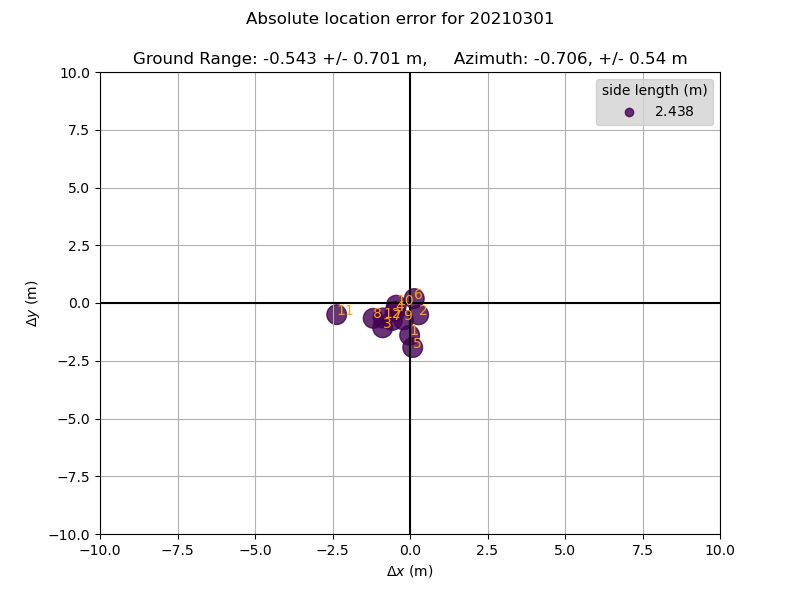

In [23]:
delays_ = delays.set_index('ID')
ALE_Rg_ = ALE_Rg - delays_['totalDelay']*2

#plotting ALE with Tropo
fig, ax = plt.subplots(figsize=(8,6))
sc = ax.scatter(ALE_Rg_, ALE_Az, s=200, c=df_filter['slen'], alpha=0.8, marker='o')
ax.legend(*sc.legend_elements(),facecolor='lightgray')
ax.get_legend().set_title('side length (m)')
for ii, txt in enumerate(df_filter.ID):
    ax.annotate(txt, (ALE_Rg_[txt], ALE_Az[txt]), color='orange')   #putting IDs in each CR
ax.grid(True)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.axhline(0, color='black')
ax.axvline(0, color='black')
ax.set_title(f'Ground Range: {np.round(np.nanmean(ALE_Rg_), 3)} +/- {np.round(np.nanstd(ALE_Rg_),3)} m, \
    Azimuth: {np.round(np.nanmean(ALE_Az),3)}, +/- {np.round(np.nanstd(ALE_Az),3)} m')
ax.set_xlabel('$\Delta x$ (m)')
ax.set_ylabel('$\Delta y$ (m)')
fig.suptitle(f'Absolute location error for {date}')
fig.savefig(f'ALE_geoSLC_deramp_tropo_{date}.png',dpi=300,bbox_inches='tight')

In [24]:
ALE_Rg_Mean = np.round(np.nanmean(ALE_Rg_), 3)
ALE_Az_Mean = np.round(np.nanmean(ALE_Az), 3)
ALE_Rg_Stdev = np.round(np.nanstd(ALE_Rg_),3)
ALE_Az_Stdev = np.round(np.nanstd(ALE_Az),3)

summary = []
summary.append([date, ALE_Rg_Mean, ALE_Rg_Stdev, ALE_Az_Mean, ALE_Az_Stdev])
summary_df = pd.DataFrame(summary)
summary_df.to_csv('ALE_withDeramp_withTropo.csv', mode='a', header=False)

In [25]:
!rm -rvf used_CRs.csv orbit weather_files GMAO* raider_CR.yaml